In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score
import os


2024-01-02 10:55:15.193317: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 10:55:15.254589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 10:55:15.254638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 10:55:15.256300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 10:55:15.265740: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 10:55:15.267139: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
BASE_PATH = 'data/ROSMAP/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [3]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(351, 202) (351, 202) (351, 202)


In [4]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
X_methy= methy_df_wol.drop('Split', axis=1).values
X_mirna = mirna_df_wol.drop('Split', axis=1).values
X_mrna = mrna_df_wol.drop('Split', axis=1).values

y = methy_df['Label'].values

In [5]:
X_methy.shape, X_mirna.shape, X_mrna.shape, y.shape

((351, 200), (351, 200), (351, 200), (351,))

In [6]:
X_methy_train, X_methy_val, X_mirna_train, X_mirna_val, X_mrna_train, X_mrna_val, y_train, y_val = train_test_split(X_methy, X_mirna, X_mrna, y, test_size=0.2, random_state=42)

In [7]:
scaler_methy = StandardScaler()
scaler_mirna = StandardScaler()
scaler_mrna = StandardScaler()
X_methy_train = scaler_methy.fit_transform(X_methy_train)
X_methy_val = scaler_methy.transform(X_methy_val)
X_mirna_train = scaler_mirna.fit_transform(X_mirna_train)
X_mirna_val = scaler_mirna.transform(X_mirna_val)
X_mrna_train = scaler_mrna.fit_transform(X_mrna_train)
X_mrna_val = scaler_mrna.transform(X_mrna_val)

In [8]:
def encoder(input_dim, output_dim, activation='relu'):
  input_layer = tf.keras.layers.Input(shape=(input_dim,))
  hidden_layer = tf.keras.layers.Dense(output_dim, activation=activation)(input_layer)
  output_layer = tf.keras.layers.Dense(output_dim, activation='linear')(hidden_layer)
  return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [9]:
def classifier(input_dim, output_dim, activation='relu'):
  input_layer = tf.keras.layers.Input(shape=(input_dim,))
  hidden_layer = tf.keras.layers.Dense(output_dim, activation=activation)(input_layer)
  output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)
  return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [10]:
# Define the hyperparameters
methy_dim = X_methy.shape[1]
mirna_dim = X_mirna.shape[1]
mrna_dim = X_mrna.shape[1]
encoding_dim = 64 # the dimension of the latent representation
classification_dim = 32 # the dimension of the hidden layer in the classification subnetwork
learning_rate = 0.01 # the learning rate for the optimizer
epochs = 100 # the number of epochs to train the model
batch_size = 32 # the batch size for the training data

In [11]:
encoder_methy = encoder(methy_dim, encoding_dim)
encoder_mirna = encoder(mirna_dim, encoding_dim)
encoder_mrna = encoder(mrna_dim, encoding_dim)

2024-01-02 10:55:18.690509: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
input_methy = tf.keras.layers.Input(shape=(methy_dim,))
input_mirna = tf.keras.layers.Input(shape=(mirna_dim,))
input_mrna = tf.keras.layers.Input(shape=(mrna_dim,))

In [13]:
encoded_methy = encoder_methy(input_methy)
encoded_mirna = encoder_mirna(input_mirna)
encoded_mrna = encoder_mrna(input_mrna)

In [14]:
concatenated = tf.keras.layers.Concatenate()([encoded_methy, encoded_mirna, encoded_mrna])

In [15]:
classifier = classifier(3 * encoding_dim, classification_dim)

In [16]:
prediction = classifier(concatenated)

In [17]:
model = tf.keras.models.Model(inputs=[input_methy, input_mirna, input_mrna], outputs=prediction)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit([X_methy_train, X_mirna_train, X_mrna_train], y_train, epochs=epochs, batch_size=batch_size, validation_data=([X_methy_val, X_mirna_val, X_mrna_val], y_val))

Epoch 1/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.7619 - val_accuracy: 0.7183
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.7640 - val_accuracy: 0.7183
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.7676 - val_accuracy: 0.7183
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.7699 - val_accuracy: 0.7183
Epoch 5/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.7715 - val_accuracy: 0.7183
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.7754 - val_accuracy: 0.7183
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.7781 - val_accuracy: 0.7183
Epoch 8/100
9/9 [====

In [23]:
y_pred = model.predict([X_methy_val, X_mirna_val, X_mrna_val])
y_pred = np.round(y_pred).flatten()
acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print('Accuracy:', acc)
print('AUC:', auc)

3/3 [==============================] - 0s 3ms/step
Accuracy: 0.7183098591549296
AUC: 0.7178571428571429


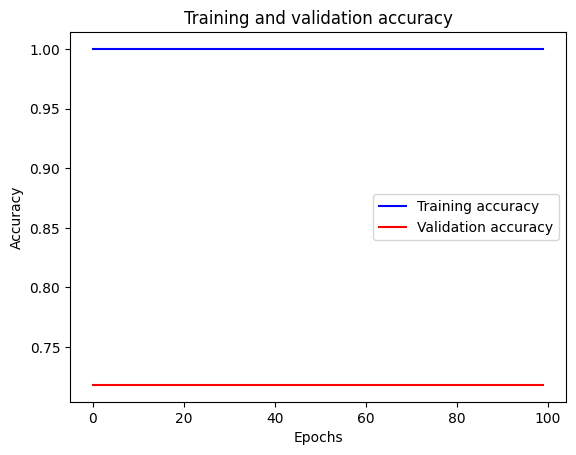

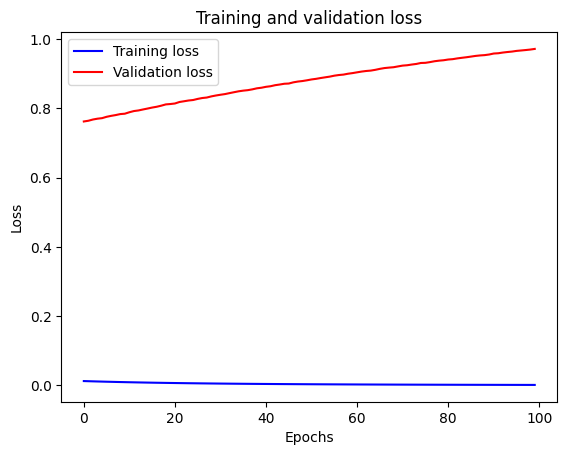

In [27]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
